# Sub-Ensembles for Fast Uncertainty Estimation

## Introduction

A common approach to obtaining high-quality estimates are **Full Ensembles**, where multiple neural networks are trained independently and their predictions are combined. While Full Ensembles are simple and highly effective, they come with substantial computational and memory cost: each model requires full training and storage. This makes them difficult to use in resource-constrained environments or during fast model development cycles.

To address these limitations, recent research has proposed **Sub-Ensembles**, a technique that retains the predictive benefits of Full Ensembles while drastically reducing training and interference overhead. Instead of training multiple full models, Sub-Ensembles share a large portion of the network (the backbone) and create several lightweight, partially independent branches (heads). These branches act as an ensemble member, providing diversity at a fraction of the computational cost.

The goal of the notebook is to:
- introduce the core idea behind (Sub-)Ensembles,
- evaluate their ability to estimate predictive uncertainty,
- compare their performance to other techniques,
- demonstrate how they can be implemented in practice.

By the end of this notebook, you will have a practical and intuitive understanding of how Sub-Ensembles work and why they represent an effective alternative for uncertainty estimation in modern neural network models.

## What are Full Ensembles?

### Ensemble

learning is a well-established technique where multiple models are trained independently and their predictions are combined to improve overall performance. The idea ist that by aggregating the outputs of several models, we can reduce variance, improve robustness and achieve better generalization than a single model. Ensembles are widely used in tasks and are particularly effective where individual models are prone to overfitting or high variance.

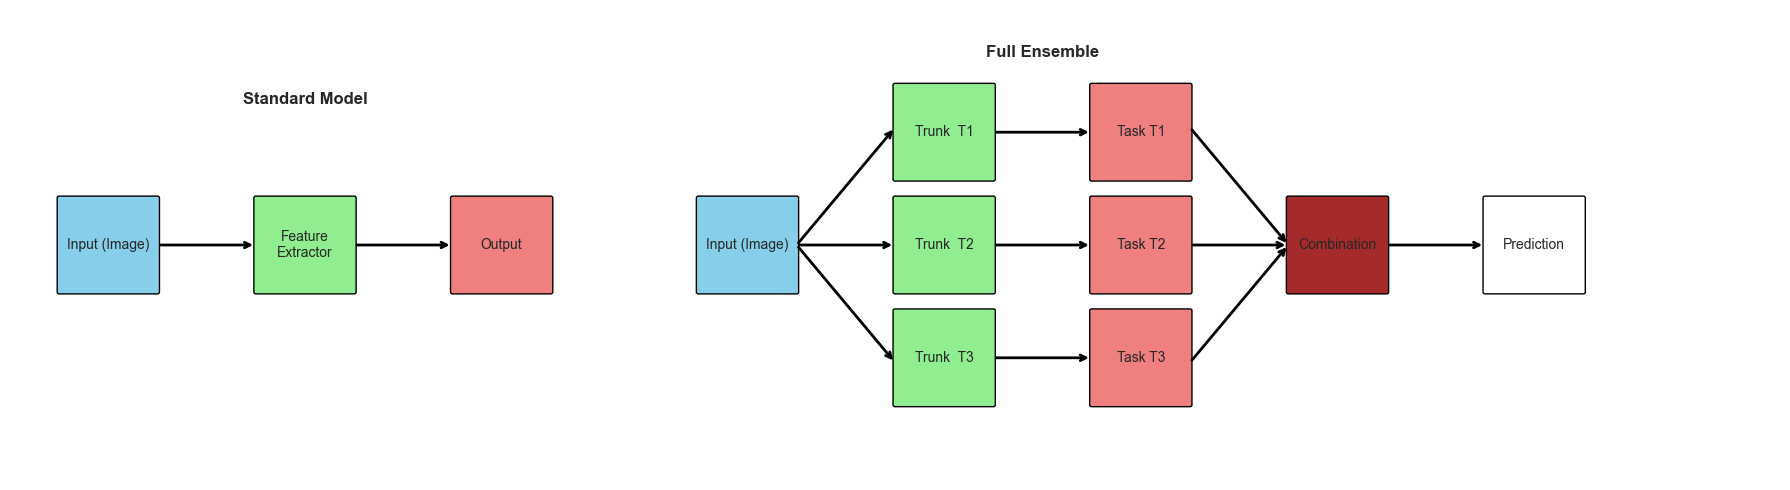

In [1]:
from matplotlib import patches
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18, 5))
ax.set_xlim(0, 18)
ax.set_ylim(0, 5)
ax.axis("off")


def draw_block(x: float, y: float, width: float, height: float, text: str, color: str = "lightblue") -> None:
    rect = patches.FancyBboxPatch((x, y), width, height, boxstyle="round,pad=0.02", edgecolor="black", facecolor=color)
    ax.add_patch(rect)
    ax.text(x + width / 2, y + height / 2, text, ha="center", va="center", fontsize=10)


def draw_arrow(x1: float, y1: float, x2: float, y2: float) -> None:
    ax.annotate("", xy=(x2, y2), xytext=(x1, y1), arrowprops={"arrowstyle": "->", "lw": 2, "color": "black"})


# -----------------------------
# Standard Model
draw_block(0.5, 2, 1, 1, "Input (Image)", color="skyblue")
draw_block(2.5, 2, 1, 1, "Feature\nExtractor", color="lightgreen")
draw_block(4.5, 2, 1, 1, "Output", color="lightcoral")
draw_arrow(1.5, 2.5, 2.5, 2.5)
draw_arrow(3.5, 2.5, 4.5, 2.5)
ax.text(3.0, 4, "Standard Model", fontsize=12, fontweight="bold", ha="center")

# -----------------------------
# Full Ensemble
ensemble_x = 9
ax.text(ensemble_x + 1.5, 4.5, "Full Ensemble", fontsize=12, fontweight="bold", ha="center")

# Input
draw_block(ensemble_x - 2.0, 2.0, 1, 1, "Input (Image)", color="skyblue")

# Three independent models
for y in [1.25, 2.5, 3.75]:
    draw_arrow(ensemble_x - 1.0, 2.5, ensemble_x, y)
for i, y in enumerate([3.2, 2, 0.8]):
    draw_block(ensemble_x, y, 1, 1, f"Trunk  T{i + 1}", color="lightgreen")
    draw_block(ensemble_x + 2.0, y, 1, 1, f"Task T{i + 1}", color="lightcoral")
    draw_arrow(ensemble_x + 1.0, y + 0.5, ensemble_x + 2.0, y + 0.5)

# Combination
for y in [1.25, 2.5, 3.75]:
    draw_arrow(ensemble_x + 3.0, y, ensemble_x + 4.0, 2.5)
draw_block(ensemble_x + 4.0, 2.0, 1, 1, "Combination", color="brown")

# Prediction
draw_arrow(ensemble_x + 5.0, 2.5, ensemble_x + 6.0, 2.5)
draw_block(ensemble_x + 6.0, 2.0, 1, 1, "Prediction", color="white")

plt.tight_layout()
plt.show()

## What are Sub-Ensembles?

A **Sub-Ensemble** generates multiple subnetworks from a single base model. This can be achieved by selectively masking parameters, activating different subsets of neurons, or using randomized heads on top of a shared feature extractor.
Since all subnetworks share the same base feature extractor (**backbone**), instead of training multiple independent neural networks from scratch, the forward pass is much faster compared to evaluating multiple fully independent networks.
Each subnetwork produces its own prediction, and the final output is obtained by averaging across all subnetworks. The **model uncertainty** is served by the variance of entropy of the predictions from each subnetwork.

Overall
- reduced memory and training cost when compared to standard (Deep) Ensembles
- reduced parameter overhead improves predictive performance and reliability of uncertainty estimates
- practical solution for robust uncertainty quantification at scale


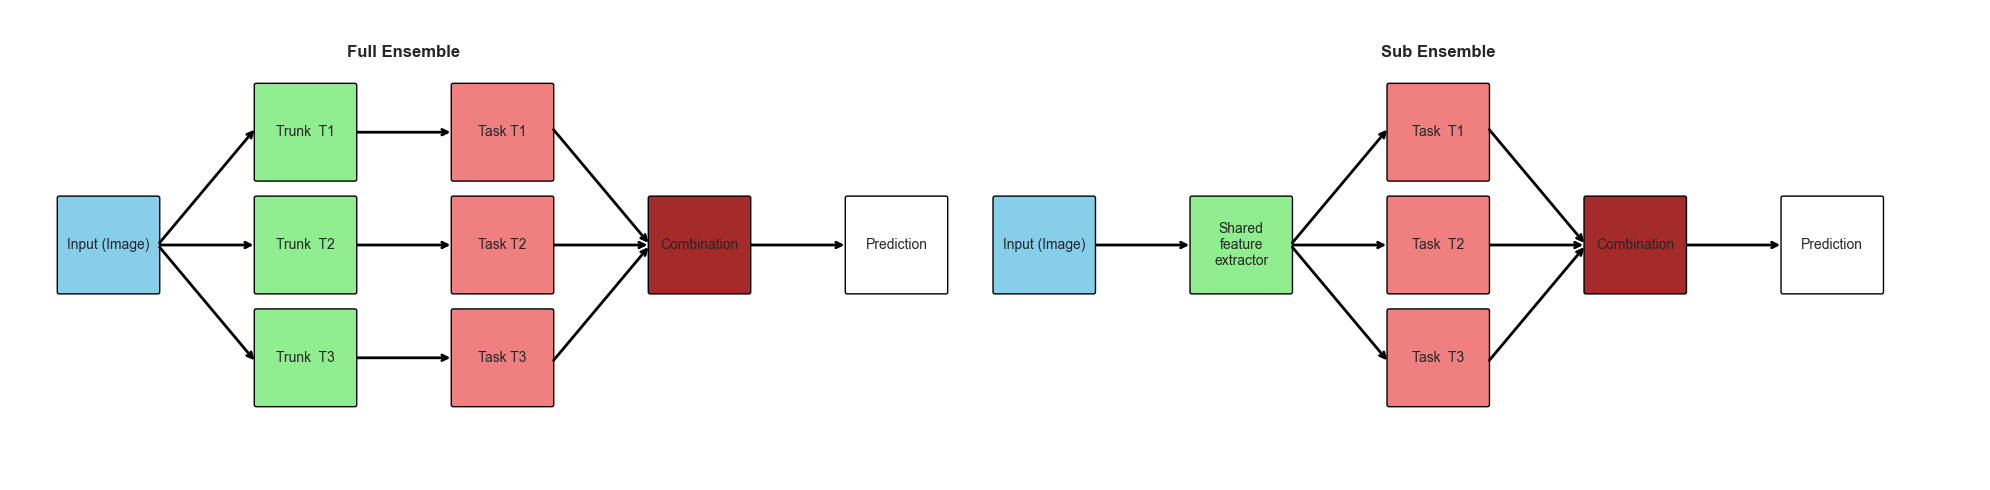

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 5))
ax.set_xlim(0, 20)
ax.set_ylim(0, 5)
ax.axis("off")


def draw_block(x: float, y: float, width: float, height: float, text: str, color: str = "lightblue") -> None:
    rect = patches.FancyBboxPatch((x, y), width, height, boxstyle="round,pad=0.02", edgecolor="black", facecolor=color)
    ax.add_patch(rect)
    ax.text(x + width / 2, y + height / 2, text, ha="center", va="center", fontsize=10)


def draw_arrow(x1: float, y1: float, x2: float, y2: float) -> None:
    ax.annotate("", xy=(x2, y2), xytext=(x1, y1), arrowprops={"arrowstyle": "->", "lw": 2, "color": "black"})


# -----------------------------
# Full Ensemble
ensemble_x = 2.5
ax.text(ensemble_x + 1.5, 4.5, "Full Ensemble", fontsize=12, fontweight="bold", ha="center")

# Input
draw_block(ensemble_x - 2.0, 2.0, 1, 1, "Input (Image)", color="skyblue")

# Three independent models
for y in [1.25, 2.5, 3.75]:
    draw_arrow(ensemble_x - 1.0, 2.5, ensemble_x, y)
for i, y in enumerate([3.2, 2, 0.8]):
    draw_block(ensemble_x, y, 1, 1, f"Trunk  T{i + 1}", color="lightgreen")
    draw_block(ensemble_x + 2.0, y, 1, 1, f"Task T{i + 1}", color="lightcoral")
    draw_arrow(ensemble_x + 1.0, y + 0.5, ensemble_x + 2.0, y + 0.5)

# Combination
for y in [1.25, 2.5, 3.75]:
    draw_arrow(ensemble_x + 3.0, y, ensemble_x + 4.0, 2.5)
draw_block(ensemble_x + 4.0, 2.0, 1, 1, "Combination", color="brown")

# Prediction
draw_arrow(ensemble_x + 5.0, 2.5, ensemble_x + 6.0, 2.5)
draw_block(ensemble_x + 6.0, 2.0, 1, 1, "Prediction", color="white")

# -----------------------------
# SubEnsemble
sub_ensemble_x = 10.0
ax.text(sub_ensemble_x + 4.5, 4.5, "Sub Ensemble", fontsize=12, fontweight="bold", ha="center")

# Input
draw_block(sub_ensemble_x, 2.0, 1, 1, "Input (Image)", color="skyblue")

# Shared Feature Extractor
draw_arrow(sub_ensemble_x + 1.0, 2.5, sub_ensemble_x + 2.0, 2.5)
draw_block(sub_ensemble_x + 2.0, 2.0, 1, 1, "Shared\nfeature\nextractor", color="lightgreen")

# Three task models
for y in [1.25, 2.5, 3.75]:
    draw_arrow(sub_ensemble_x + 3.0, 2.5, sub_ensemble_x + 4.0, y)
for i, y in enumerate([3.2, 2, 0.8]):
    draw_block(sub_ensemble_x + 4.0, y, 1, 1, f"Task  T{i + 1}", color="lightcoral")

# Combination
for y in [1.25, 2.5, 3.75]:
    draw_arrow(sub_ensemble_x + 5.0, y, sub_ensemble_x + 6.0, 2.5)
draw_block(sub_ensemble_x + 6.0, 2.0, 1, 1, "Combination", color="brown")

# Prediction
draw_arrow(sub_ensemble_x + 7.0, 2.5, sub_ensemble_x + 8.0, 2.5)
draw_block(sub_ensemble_x + 8.0, 2.0, 1, 1, "Prediction", color="white")

plt.tight_layout()
plt.show()

## Evaluation of Sub-Ensembles

To empirically evaluate the benefits of Sub-Ensembles, we conducted a series of experiments on the CIFAR-10 dataset. Using a compact convolutional neural network (CNN) as our base mode, we compare traditional training approaches - such as single networks, dropout and dropconnect - with both Full Ensembles and Sub-Ensembles.

By systematically varying the number of ensemble members and the size of each subnetwork, we can observe how sub-ensembles trade off between **computational efficiency, predictive performance** and **uncertainty estimation quality**. The experiments demonstrate evaluation metrics such as accuracy, cross-entropy loss, predictive entropy, confidence and training time. This setup provides a clear, reproducible framework to assess the performance of Sub-Ensembles relative to other probabilistic modelling techniques.

### Understanding the values

1. **Accuracy**
    - The fraction of correctly classified samples over the total number of samples.
    - Higher accuracy indicates better overall predictive performance.
2. **Loss**
    - Cross-entropy loss measures how well the predicted probability distribution matches the true labels.
    - Lower loss indicates that the model´s predicted probabilities are closer to the true labels, not just the final predicted class. Loss can reveal miscalibrated confidence even if accuracy is high.
3. **Mean Predictive Entropy**
    - Average entropy of the predicted probability distribution per sample. It quantifies uncertainty in the predictions.
    - High entropy means the model is uncertain, spreading probability across multiple classes while low entropy means the model is confident, concentrating probability on one class.
4. **Mean Confidence**
    - The average of $1 - $ (maximum predicted probability per sample). It measures how "unsure" the model is in its top prediction.
    - High confidence means the model is unsure while low confidence means the model is confident in its predictions
5. **Training Time**
    -  The total time the model or ensemble task takes to complete training.

**Keeping it simple**
- **Accuracy** and **Loss** measure predictive performance,
- **Entropy** and **Confidence** quantify model uncertainty,
- **Training Time** informs about computational cost.

### The short run

Parameters:
- 16 channels in first layer
- 32 channels in second layer
- 64 neurons in fully connected layer

- 64 batch size for Training
- 128 batch size for Evaluation
- 3 Epochs for base mode, dropout and dropconnect
- 2 Epochs for ensemble and subensemble
- 3 ensemble member and subensemble heads
- 0.5 dropout_p and dropconnect_p

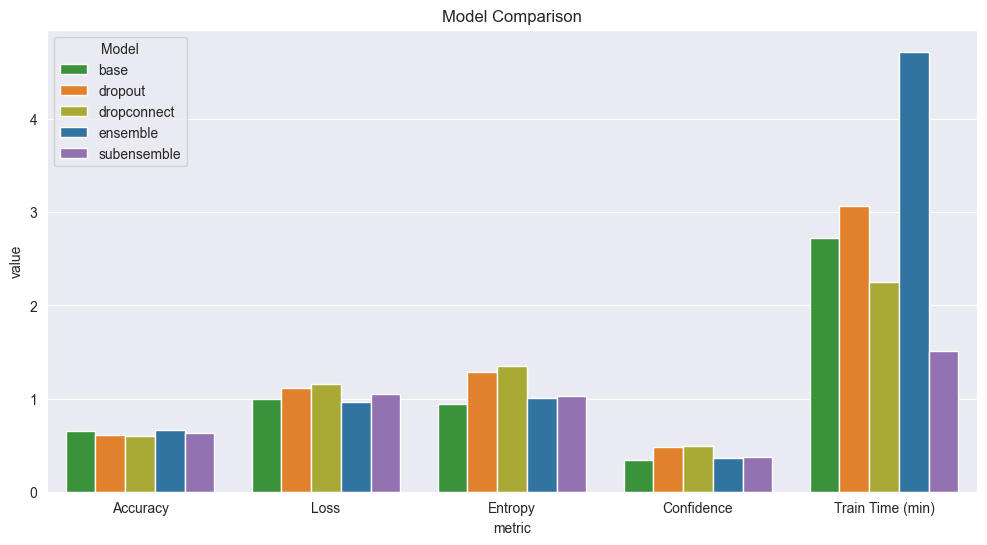

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

results = {
    "base": {
        "acc": 0.6539,
        "loss": 0.9954628388404846,
        "entropy": 0.943705764579773,
        "confidence": 0.3400328187942505,
        "train_time": 163.6083629131317,
    },
    "dropout": {
        "acc": 0.6065,
        "loss": 1.1155516721725465,
        "entropy": 1.286688205909729,
        "confidence": 0.47807708315849307,
        "train_time": 184.05619478225708,
    },
    "dropconnect": {
        "acc": 0.5942,
        "loss": 1.1548779750823974,
        "entropy": 1.3506039510726928,
        "confidence": 0.48927073521614073,
        "train_time": 134.803480386734,
    },
    "ensemble": {
        "acc": 0.6664,
        "loss": 0.9580384889602661,
        "entropy": 1.0090041233062743,
        "confidence": 0.3605740736961365,
        "train_time": 283.3922255039215,
    },
    "subensemble": {
        "acc": 0.6257,
        "loss": 1.046180512905121,
        "entropy": 1.0244406782150268,
        "confidence": 0.3720386128425598,
        "train_time": 90.45244002342224,
    },
}

data = []
for model, vals in results.items():
    data.append({"model": model, "metric": "Accuracy", "value": vals["acc"]})
    data.append({"model": model, "metric": "Loss", "value": vals["loss"]})
    data.append({"model": model, "metric": "Entropy", "value": vals["entropy"]})
    data.append({"model": model, "metric": "Confidence", "value": vals["confidence"]})
    data.append({"model": model, "metric": "Train Time (min)", "value": vals["train_time"] / 60})

df = pd.DataFrame(data)


colors = {
    "base": "tab:green",
    "dropout": "tab:orange",
    "dropconnect": "tab:olive",
    "ensemble": "tab:blue",
    "subensemble": "tab:purple",
}

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="metric", y="value", hue="model", palette=colors)
plt.title("Model Comparison")
plt.legend(title="Model")
plt.show()

We can see clear differences between the various models:
- The **base model** achieves a solid accuracy of 65.4% with relatively low loss, indicating decent performance for a single network.
However, its predictive uncertainty is also the lowest among the models, reflected in a mean entropy of 0.94 and a mean confidence of 0.34, suggesting that it is somewhat overconfident in its predictions.

- Introducing stochasticity through **dropout** and **dropconnect** slightly decreases accuracy (60.7% and 59.4% respectively) and increases loss, but significantly raises both mean entropy and mean confidence. This demonstrates that these methods successfully capture predictive uncertainty, albeit at the cost of raw accuracy.

- The **Full Ensemble** model achieves the highest accuracy (66.6%) with low loss, while maintaining moderate entropy (1.01) and confidence (0.36). This indicates that ensembles not only improve predictive performance but also provide calibrated uncertainty estimates.

- Finally, the **Sub-Ensemble** model provides a compromise: accuracy of 62.6% and loss slightly higher that the base mode, with uncertainty measures closer to the ensemble. Its notably shorter training time highlights its efficiency as a fast approximation to full ensembles, making it a promising approach to practical applications where both uncertainty estimation and computational cost are concerns.

### The long run

Parameters:
- 32 channels in first layer
- 64 channels in second layer
- 256 neurons in fully connected layer

- 128 batch size for Training
- 256 batch size for Evaluation
- 10 Epochs for base mode, dropout and dropconnect
- 8 Epochs for ensemble and subensemble
- 5 ensemble member and subensemble heads
- 0.5 dropout_p and dropconnect_p

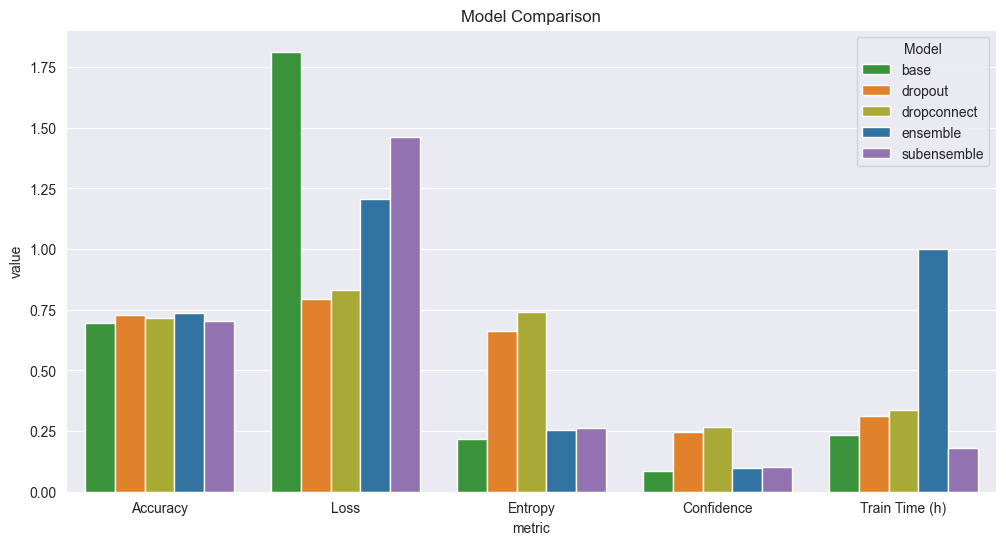

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

results = {
    "base": {
        "acc": 0.6955,
        "loss": 1.8135123289108277,
        "entropy": 0.21580944175720215,
        "confidence": 0.08432607227563858,
        "train_time": 841.9727296829224,
    },
    "dropout": {
        "acc": 0.7291,
        "loss": 0.7940595424652099,
        "entropy": 0.6627747758865357,
        "confidence": 0.24513579890727996,
        "train_time": 1130.0001056194305,
    },
    "dropconnect": {
        "acc": 0.7148,
        "loss": 0.8307193132400512,
        "entropy": 0.7387115199565888,
        "confidence": 0.2664609573125839,
        "train_time": 1210.7464382648468,
    },
    "ensemble": {
        "acc": 0.7352,
        "loss": 1.2056888597488404,
        "entropy": 0.2545359429597855,
        "confidence": 0.09759825307130814,
        "train_time": 3603.2559394836426,
    },
    "subensemble": {
        "acc": 0.7016,
        "loss": 1.463328649520874,
        "entropy": 0.26385503091812135,
        "confidence": 0.10132622718811035,
        "train_time": 643.0661900043488,
    },
}

data = []
for model, vals in results.items():
    data.append({"model": model, "metric": "Accuracy", "value": vals["acc"]})
    data.append({"model": model, "metric": "Loss", "value": vals["loss"]})
    data.append({"model": model, "metric": "Entropy", "value": vals["entropy"]})
    data.append({"model": model, "metric": "Confidence", "value": vals["confidence"]})
    data.append({"model": model, "metric": "Train Time (h)", "value": vals["train_time"] / 60 / 60})

df = pd.DataFrame(data)


colors = {
    "base": "tab:green",
    "dropout": "tab:orange",
    "dropconnect": "tab:olive",
    "ensemble": "tab:blue",
    "subensemble": "tab:purple",
}

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="metric", y="value", hue="model", palette=colors)
plt.title("Model Comparison")
plt.legend(title="Model")
plt.show()

The long run experiments reveal more stable and mature patterns compared to the short run.

- The **base model** reaches an accuracy of 69.6%, but the predictive uncertainty is very low, with mean entropy of 0.22 and mean confidence of 0.08, indicating that the network is highly confident but potentially overconfident in its predictions.

- Using **dropout** and **dropconnect** improves accuracy further (72.9% and 71.5% respectively) and reduces loss, while also increasing the predictive uncertainty (entropy 0.66-0.74, confidence 0.25-0.27). This shows that stochastic regularization not only enhances performance but provides better calibrated uncertainty estimates.

- The **Full Ensemble** model achieves the highest accuracy (73.5%), with moderate predictive uncertainty (entropy 0.25, confidence 0.10). Despite its significantly longer training time (~60min), it demonstrates how combining multiple models can yield both high performance and reliable uncertainty estimates.

- The **Sub-Ensemble** model achieves balance between efficiency and performance: accuracy of 70.2%, entropy 0.26 and confidence 0.10, while requiring substantially less training time (~10.5min) than the full ensemble. This confirms that Sub-Ensembles are an effective approach for fast yet reliable uncertainty estimation.

### Conclusion

Full Ensembles deliver the most robust predictions and the most calibrated uncertainty estimates at high computational cost.
Sub-Ensembles, while slightly less accurate, offer a much more efficient alternative while retaining the uncertainty benefits. They offer a **promising middle ground** with comparable uncertainty quality at a fraction of the training time.

## Code Demo

This snippet shows how a simple sequential base model is repurposed into a Sub-Ensemble model. The base model is split into a shared feature extractor and multiple independent heads, which are initialized separately. The output is obtained by averaging the head predictions during the forward pass.

In [5]:
import copy

import torch
from torch import nn

base_model = nn.Sequential(
    nn.Linear(2, 2),
    nn.Linear(2, 2),
    nn.Linear(2, 2),
)


class SubEnsemble(nn.Module):
    """Sub-Ensemble model that repurposes a base model into multiple heads sharing the same feature extractor."""

    def __init__(self, model: nn.Module, n_heads: int = 3) -> None:
        """Initialize the sub-ensemble model."""
        super().__init__()

        self.n_heads = n_heads

        if not isinstance(model, nn.Sequential) or len(model) < 2:
            msg = "Base model must be an nn.Sequential with at least 2 layers."
            raise ValueError(msg)

        # Shared feature extractor = all layers except last
        self.feature_extractor = nn.Sequential(*model[:-1])

        # Last layer of the base model
        last_layer = model[-1]

        # Create multiple head copies
        self.heads = nn.ModuleList()
        for _ in range(n_heads):
            new_head = copy.deepcopy(last_layer)

            # Reinitialize parameters
            for layer in new_head.modules():
                if hasattr(layer, "reset_parameters"):
                    layer.reset_parameters()

            self.heads.append(new_head)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass."""
        # Shared feature Extractor
        features = self.feature_extractor(x)

        # Each head produces a prediction
        outputs = [head(features) for head in self.heads]

        # Stack + Mean
        return torch.stack(outputs).mean(dim=0)


# Transform base_model into Sub-Ensemble with 3 heads
sub_ensemble = SubEnsemble(base_model, n_heads=3)

# Output
print("Base model:", base_model)
print("Base model type:", type(base_model))
print("Is Sub-Ensemble?", isinstance(base_model, SubEnsemble))
print("SubEnsemble:", sub_ensemble)
print("SubEnsemble type:", type(sub_ensemble))
print("Is Sub-Ensemble?", isinstance(sub_ensemble, SubEnsemble))

Base model: Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Linear(in_features=2, out_features=2, bias=True)
  (2): Linear(in_features=2, out_features=2, bias=True)
)
Base model type: <class 'torch.nn.modules.container.Sequential'>
Is Sub-Ensemble? False
SubEnsemble: SubEnsemble(
  (feature_extractor): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Linear(in_features=2, out_features=2, bias=True)
  )
  (heads): ModuleList(
    (0-2): 3 x Linear(in_features=2, out_features=2, bias=True)
  )
)
SubEnsemble type: <class '__main__.SubEnsemble'>
Is Sub-Ensemble? True


### Notes
Note that the heads can also be created by using the already implemented generate_torch_ensemble function from probly

In [6]:
from probly.transformation.ensemble.torch import generate_torch_ensemble

head, num_heads = [nn.Linear(2, 2), 3]

heads = generate_torch_ensemble(head, num_heads)

heads

ModuleList(
  (0-2): 3 x Linear(in_features=2, out_features=2, bias=True)
)

SubEnsemble can then be defined like this:

In [7]:
import torch
from torch import nn

from probly.transformation.ensemble.torch import generate_torch_ensemble

base_model = nn.Sequential(
    nn.Linear(2, 2),
    nn.Linear(2, 2),
    nn.Linear(2, 2),
)


class SubEnsemble(nn.Module):
    """Sub-Ensemble model that repurposes a base model into multiple heads sharing the same feature extractor."""

    def __init__(self, model: nn.Module, n_heads: int = 3) -> None:
        """Initialize."""
        super().__init__()

        self.n_heads = n_heads

        if not isinstance(model, nn.Sequential) or len(model) < 2:
            msg = "Base model must be an nn.Sequential with at least 2 layers."
            raise ValueError(msg)

        # Create feature extractor
        self.feature_extractor = nn.Sequential(*base_model[:-1])

        # Create n_heads heads
        self.heads = generate_torch_ensemble(base_model[-1], n_heads)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass."""
        features = self.feature_extractor(x)
        outputs = [h(features) for h in self.heads]
        return torch.stack(outputs).mean(dim=0)


# Transform base model
sub_ensemble = SubEnsemble(base_model, n_heads=3)

# Output
print("SubEnsemble:", sub_ensemble)

SubEnsemble: SubEnsemble(
  (feature_extractor): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Linear(in_features=2, out_features=2, bias=True)
  )
  (heads): ModuleList(
    (0-2): 3 x Linear(in_features=2, out_features=2, bias=True)
  )
)
